In [3]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
#import statsmodels.api as sm

/Users/philsolenthaler 1/Documents/Universität/BCS/3.Semester/Statistik/DatenbankenProjetk/Statistik-Datenbank/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")


In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(s, bins="fd", color="pink", edgecolor="purple", stat="count")
plt.xscale("log")
plt.title("Verteilung: Amt (log-Skala)")
plt.xlabel("Amt (log)")
plt.ylabel("Anzahl")
plt.legend()
plt.show()
#Ich habe die x-Achse auf eine logarithmische Skala gesetzt, um die Verteilung besser darzustellen. Provisorisch falls wir das für die 3. Vorlesung brauchen

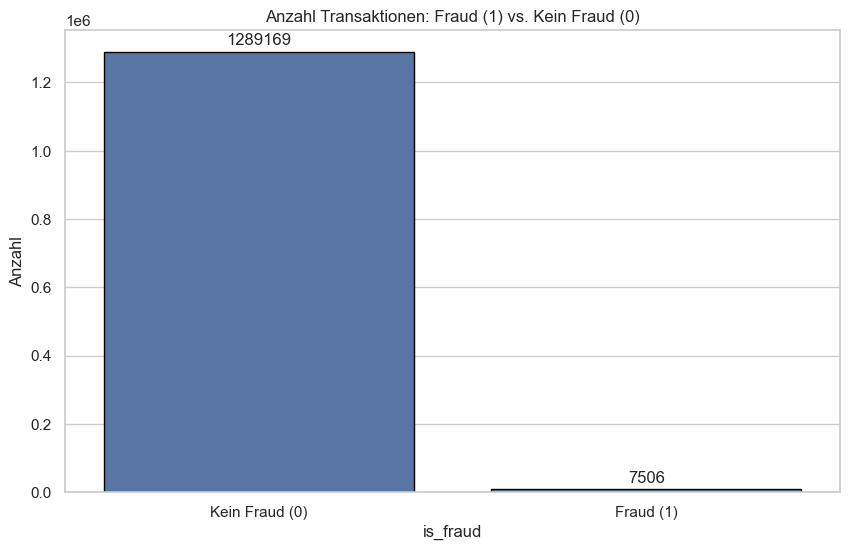

In [13]:
plt.figure()
ax = sns.countplot(x="is_fraud", data=ds, edgecolor="black")

plt.title("Anzahl Transaktionen: Fraud (1) vs. Kein Fraud (0)")
plt.xlabel("is_fraud")
plt.ylabel("Anzahl")
plt.xticks([0, 1], ["Kein Fraud (0)", "Fraud (1)"])

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3)

In [ ]:
# Kategorien-Auflistung der Anzahl Transaktionen
ds["category"].unique()
ds["category"].nunique()
ds["category"].value_counts()

category
gas_transport     131659
grocery_pos       123638
home              123115
shopping_pos      116672
kids_pets         113035
shopping_net       97543
entertainment      94014
food_dining        91461
personal_care      90758
health_fitness     85879
misc_pos           79655
misc_net           63287
grocery_net        45452
travel             40507
Name: count, dtype: int64


Wir wollen anschauen, welches Geschlecht in welcher Kategorie mehr Transaktionen durchgeführt hat. Dazu haben wir zuerst Vermutungen zu den Kategorien aufgestellt

- misc_net: Keine Vermutung da dies die Daten von nicht zugeordneten online Transaktionen sind
- misc_pos: Keine Vermutung da dies die Daten von nicht zugeordneten physischen Transaktionen sind
- grocery_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- grocery_net Mehr Frauen haben diese Transaktionen durchgeführt
- entertainment: Mehr Männer haben diese Transaktionen durchgeführt
- gas_transport: Mehr Männer haben diese Transaktionen durchgeführt
- shopping_net: Mehr Frauen haben diese Transaktionen durchgeführt
- shopping_pos: Mehr Frauen haben diese Transaktionen durchgeführt
- food_dining: Mehr Männer haben diese Transaktionen durchgeführt
- personal_care: Mehr Frauen haben diese Transaktionen durchgeführt
- health fitness: Wir denken hier sind beide Geschlechter gleich auf oder die Frauen leicht im mehr.
- travel: Mehr Männer haben diese Transaktionen durchgeführt
- kids_pets: Mehr Männer haben diese Transaktionen durchgeführt
- home: Mehr Männer haben diese Transaktionen durchgeführt

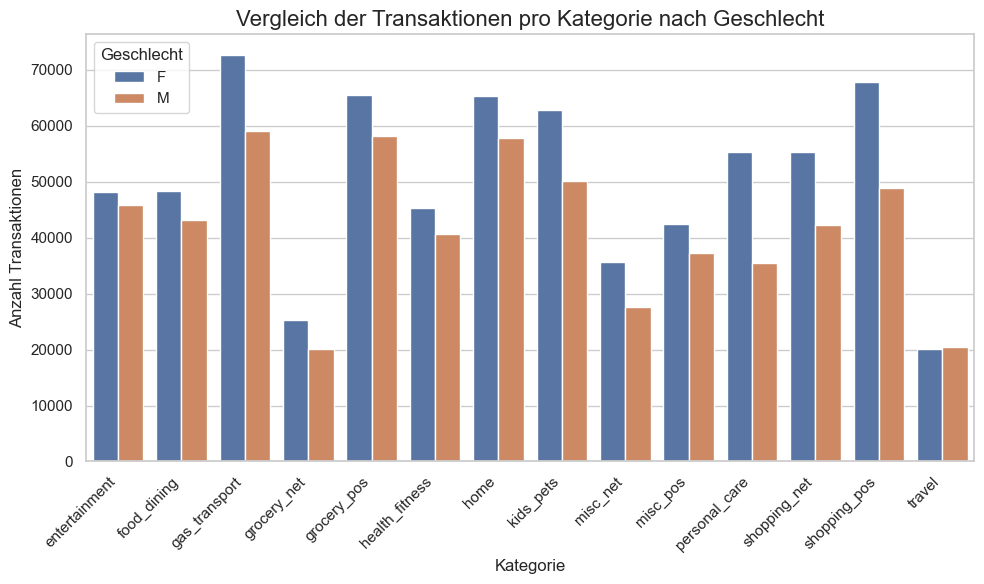

In [8]:
sns.set(style="whitegrid")

# Gruppieren nach Kategorie und Geschlecht und die Anzahl zählen
category_gender_counts = ds.groupby(['category', 'gender']).size().reset_index(name='count')

# Balkendiagramm erstellen
plt.figure()
sns.barplot(x='category', y='count', hue='gender', data=category_gender_counts)

# Diagramm anpassen
plt.title("Vergleich der Transaktionen pro Kategorie nach Geschlecht", fontsize=16)
plt.xlabel("Kategorie", fontsize=12)
plt.ylabel("Anzahl Transaktionen", fontsize=12)
plt.xticks(rotation=45, ha='right')  # x-Achsenbeschriftungen lesbar machen
plt.legend(title='Geschlecht')
plt.tight_layout()

### Evaluierung:

Wir sehen, dass in jeder Kategorie die Frau mehr Transaktionen durchführt als der Mann den einzigen kleinen Unterschied liegt beid er Kategorie travel wo der Mann leicht mehr Transaktionen macht als die Frau.


# Amount Spent
We analyze the overall spending amounts, the distribution of spending across categories, 
and how spending behavior differs between genders.

Text(0, 0.5, 'Anzahl Transaktionen')

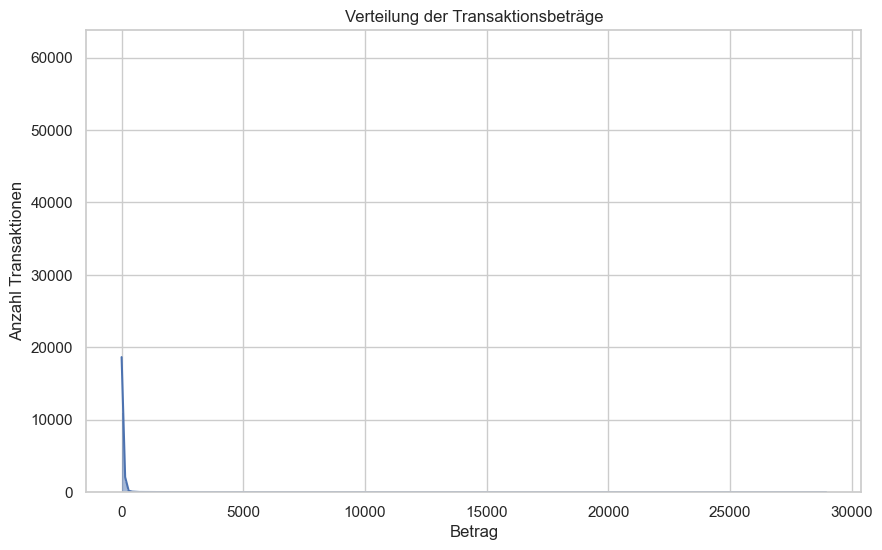

In [9]:
#we look at the amounts spent over all for the transactions and then we compare the amounts spent by category and then by gender
plt.figure()
sns.histplot(ds['amt'], bins='fd', kde=True)
plt.title("Verteilung der Transaktionsbeträge")
plt.xlabel("Betrag")
plt.ylabel("Anzahl Transaktionen")


Text(0.5, 0, 'Betrag')

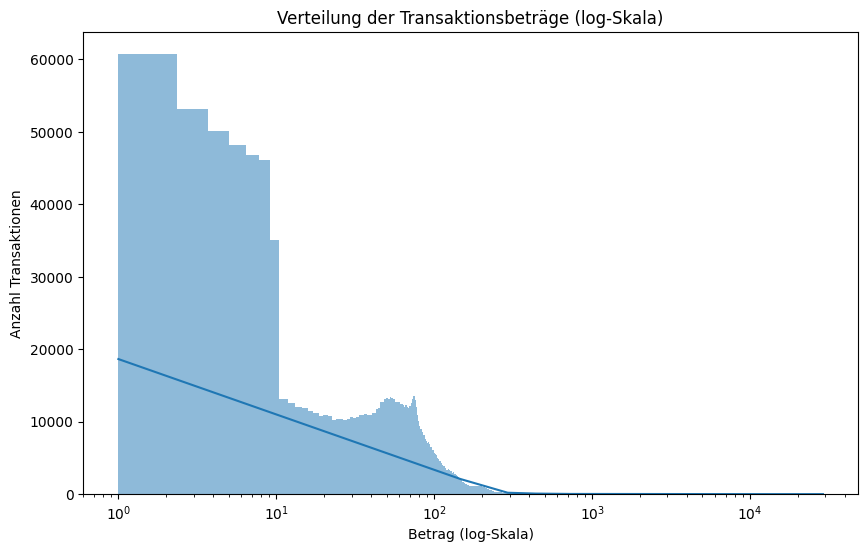

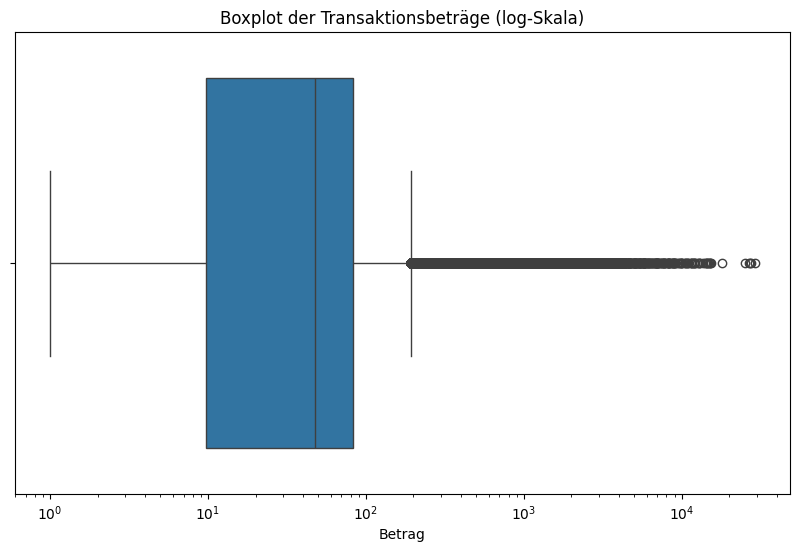

In [6]:
# Logarithmische Skala für die Beträge damit man die Verteilung besser sieht
sns.histplot(ds['amt'], bins='fd', kde=True)
plt.xscale('log')
plt.title("Verteilung der Transaktionsbeträge (log-Skala)")
plt.xlabel("Betrag (log-Skala)")
plt.ylabel("Anzahl Transaktionen")

plt.figure()
sns.boxplot(x=ds['amt'])
plt.xscale('log')
plt.title("Boxplot der Transaktionsbeträge (log-Skala)")
plt.xlabel("Betrag")

Text(0, 0.5, 'Betrag')

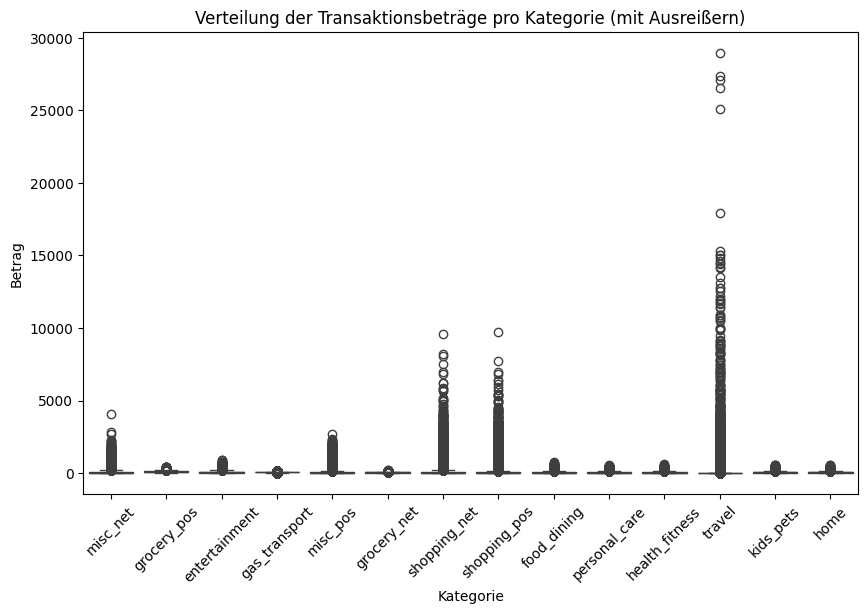

In [9]:
# Boxplot der Beträge pro Kategorie um Ausreißer zu visualisieren
plt.figure()
sns.boxplot(data=ds, x='category', y='amt')
plt.xticks(rotation=45)
plt.title("Verteilung der Transaktionsbeträge pro Kategorie (mit Ausreißern)")
plt.xlabel("Kategorie")
plt.ylabel("Betrag")

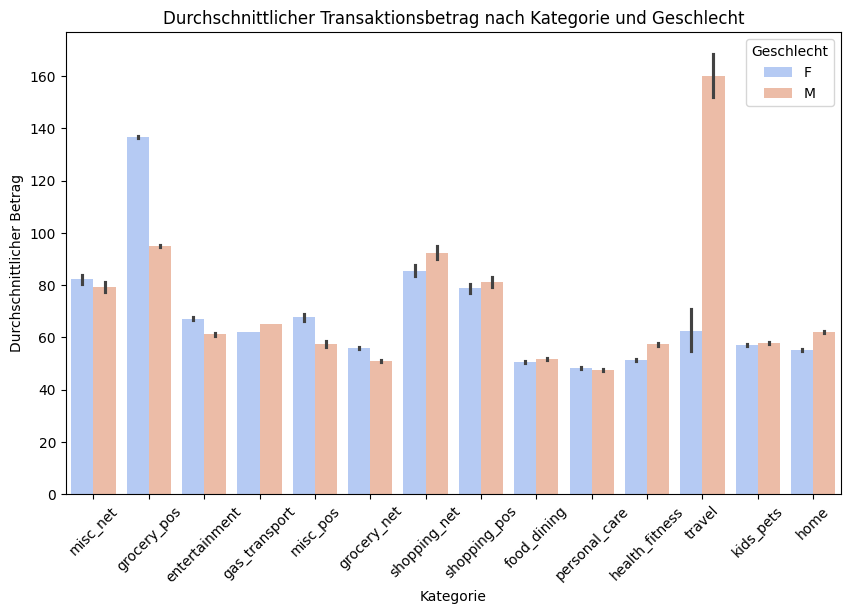

In [12]:
# Durchschnittlicher Betrag pro Kategorie und Geschlecht
plt.figure()
sns.barplot(data=ds, x='category', y='amt', hue='gender', estimator='mean', palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Durchschnittlicher Transaktionsbetrag nach Kategorie und Geschlecht")
plt.ylabel("Durchschnittlicher Betrag")
plt.xlabel("Kategorie")
plt.legend(title="Geschlecht")

/var/folders/cj/7vlgj44s1rv8_1ymt1nm1qpm0000gp/T/ipykernel_4482/216290753.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=ds, x='gender', y='amt', palette='pastel')


Text(0, 0.5, 'Betrag')

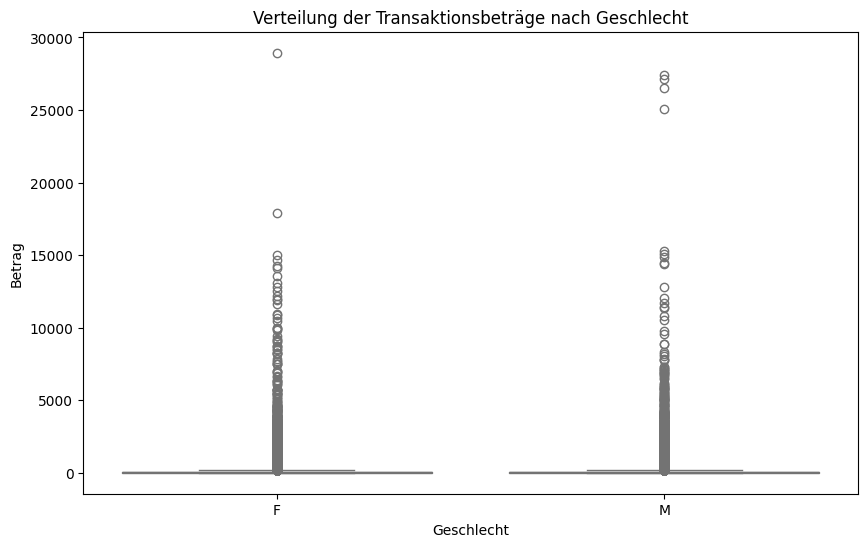

In [13]:
# Boxplot der Beträge nach Geschlecht
plt.figure()
sns.boxplot(data=ds, x='gender', y='amt', palette='pastel')
plt.title("Verteilung der Transaktionsbeträge nach Geschlecht")
plt.xlabel("Geschlecht")
plt.ylabel("Betrag")



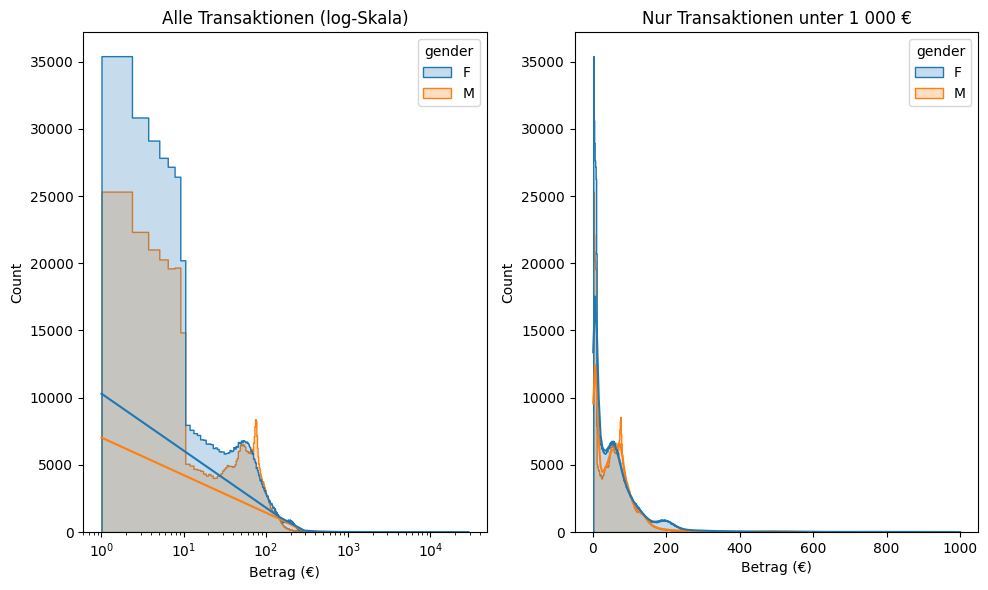

In [15]:
fig, axes = plt.subplots(1, 2)

sns.histplot(data=ds, x='amt', hue='gender', bins='fd', kde=True, element='step', ax=axes[0])
axes[0].set_title("Alle Transaktionen (log-Skala)")
axes[0].set_xlabel("Betrag (€)")
axes[0].set_xscale('log')

sns.histplot(data=ds[ds['amt'] < 1000], x='amt', hue='gender', bins='fd', kde=True, element='step', ax=axes[1])
axes[1].set_title("Nur Transaktionen unter 1 000 €")
axes[1].set_xlabel("Betrag (€)")

plt.tight_layout()